In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!pip install transformers~=3.5.1

In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd

import torchtext.data as ttd

import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
from torch.utils import data
import torch.nn as nn
import torch.optim.lr_scheduler
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import gensim 
import gensim.downloader as api
from gensim.models import Word2Vec  
#from torchnlp.word_to_vector import GloVe, FastText
import torchtext.data as ttd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, word_tokenize, sent_tokenize, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from nltk.stem.porter import PorterStemmer 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
#from warnings import simplefilter
#simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.datasets import fetch_20newsgroups
from transformers import BertTokenizer
import transformers as tran

from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
folder=Path('/content/gdrive/MyDrive/NLP')

In [5]:
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [6]:
df1 = pd.DataFrame([train.data, train.target.tolist()]).T
df1.columns = ['text', 'target']

targets = pd.DataFrame( train.target_names)
targets.columns=['title']

df_train = pd.merge(df1, targets, left_on='target', right_index=True)
df_train

,text,target,title
0,I was wondering if anyone out there could enli...,7,rec.autos
17,I recently posted an article asking what kind ...,7,rec.autos
29,\nIt depends on your priorities. A lot of peo...,7,rec.autos
56,an excellent automatic can be found in the sub...,7,rec.autos
64,: Ford and his automobile. I need information...,7,rec.autos
...,...,...,...
11210,Secrecy in Clipper Chip\n\nThe serial number o...,11,sci.crypt
11217,Hi !\n\nI am interested in the source of FEAL ...,11,sci.crypt
11243,"The actual algorithm is classified, however, t...",11,sci.crypt
11254,\n\tThis appears to be generic calling upon th...,11,sci.crypt


In [7]:
df2 = pd.DataFrame([test.data, test.target.tolist()]).T
df2.columns = ['text', 'target']

targets1 = pd.DataFrame( test.target_names)
targets1.columns=['title']

df_test = pd.merge(df2, targets1, left_on='target', right_index=True)
df_test

,text,target,title
0,I am a little confused on all of the models of...,7,rec.autos
27,I have a 90 Eagle Talon and I wanted a pair of...,7,rec.autos
28,"Hi,\nI need your help with a problem I have wi...",7,rec.autos
75,\nThey changed the lights and slope of the hoo...,7,rec.autos
77,I am thinking of buying a used Audi 90 Auto.\n...,7,rec.autos
...,...,...,...
7426,\nI think it's because the lead gets coated wi...,12,sci.electronics
7445,"\n\nWith regards to what you wrote, how does ...",12,sci.electronics
7507,\nWhy can't he record it legally? It may not ...,12,sci.electronics
7510,\n\n\nIt sorta depends on what you drive. I re...,12,sci.electronics


In [8]:
print(df_train.title.values)

['rec.autos' 'rec.autos' 'rec.autos' ... 'sci.crypt' 'sci.crypt'
 'sci.crypt']


In [9]:
print(df_train.title.value_counts)

<bound method IndexOpsMixin.value_counts of 0        rec.autos
17       rec.autos
29       rec.autos
56       rec.autos
64       rec.autos
           ...    
11210    sci.crypt
11217    sci.crypt
11243    sci.crypt
11254    sci.crypt
11302    sci.crypt
Name: title, Length: 11314, dtype: object>


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


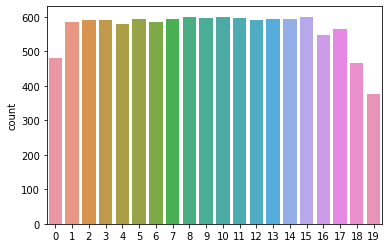

In [10]:
# Plot the number of tokens of each length.
sns.countplot(train.target);

Experiment-3

In [11]:
from transformers import BertTokenizer

# Loading the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=True)

Loading BERT tokenizer...


In [12]:
sentences = df_train.text.values
labels = df_train.target.values

In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        #padding = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
       
    input_ids.append(encoded_dict['input_ids'])
    
    
    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels=torch.tensor(df_train['target'])


print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Token IDs: tensor([  101,   178,  1108,  6123,  1191,  2256,  1149,  1175,  1180,  4035,
         4568,  1424,  1143,  1113,  1142,  1610,   178,  1486,  1103,  1168,
         1285,   119,  1122,  1108,   170,   123,   118,  1442,  2865,  1610,
          117,  1350,  1106,  1129,  1121,  1103,  1523, 22891,   120,  1346,
        19025,   119,  1122,  1108,  1270,   170,  5003,  2836,   119,  1103,
         3581,  1127,  1541,  1353,   119,  1107,  1901,   117,  1103,  1524,
        26035,  1108,  2767,  1121

In [14]:
# train-validation split.
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,919 training samples
3,395 validation samples


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# We reduced the batch size because we are getting Run-Time out of memory error 

# we tried different batch sizes like 16, 8, 4 only 2 is working for us
batch_size = 2

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size 
        )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-large-cased", 
    num_labels = 20,  
    output_attentions = False, 
    output_hidden_states = False, 
)
model.cuda();

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [17]:
#INSTANTIATING OPTIMIZER CLASS
epochs = 2
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() 
          if not any(nd in n for nd in no_decay)], 
         'weight_decay': 0.5},

        {'params': [p for n, p in model.named_parameters() 
        if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0}
        ]

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 5e-5, 
                  eps = 1e-8 
                )

no_decay = ['bias', 'LayerNorm.weight']



from transformers import get_linear_schedule_with_warmup


total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda', index=0)

In [19]:
import random
from datetime import datetime

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

epochs = 2

# TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    # forward pass

    loss, logits = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)


    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
    # forward pass

      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/2, Train Loss: 3.0505    Valid Loss: 3.0154, Duration: 0:21:43.160505
Epoch 2/2, Train Loss: 3.0224    Valid Loss: 2.9958, Duration: 0:21:41.714672


In [23]:
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
    # forward pass

      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)

      _,indices = torch.max(logits,dim=1)
      correct+= (b_labels==indices).sum().item()
      total += b_labels.shape[0]
    
    acc= correct/total

    return acc

In [24]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)

In [25]:
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f}')

Train acc: 0.0547,	 Valid acc: 0.0465


In [27]:
# Write a function to get predictions

def get_predictions(data_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in data_iter:
      
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
    # forward pass

      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)
      
      _,indices = torch.max(logits,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,b_labels.cpu().numpy())) 
      
  return y_test, predictions

In [28]:
y_valid, predictions=get_predictions(validation_dataloader, model)

In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid,predictions)
cm

array([[  0,   0, 150,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 167,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 158,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 176,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 165,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 195,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 176,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 202,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 185,   0,   0,   0,   0,   0,   0,   0,   0,  

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

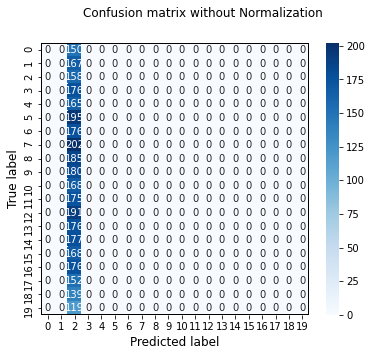

In [31]:
plot_confusion_matrix(y_valid,predictions)

In [ ]:
# Since the batch size is 2, we believe that predictions going to label 2 based on confusion matrix we got